In [124]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [125]:
!ls
!pip install kaggle

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"cedwards57","key":"ed13ac8e0ba7313249ba57cc7e8cce8b"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!chmod 600 /content/.kaggle/kaggle.json
#!kaggle config path -p /content
!kaggle competitions download -c csc4851-homework4
!unzip csc4851-homework4.zip
# if you have to rerun the code after already downloading, enter a capital "N" in the console when prompted
!pip install catalyst

birds_400  csc4851-homework4.zip  sample_data  save_model  submission.csv
mkdir: cannot create directory ‘/root/.kaggle’: File exists
chmod: cannot access '/content/.kaggle/kaggle.json': No such file or directory
csc4851-homework4.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  csc4851-homework4.zip
replace birds_400/birds latin names.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catalyst import dl, utils

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [127]:
import os
directories = ['./birds_400/test',
                                './birds_400/train',
                                './birds_400/valid']

for dir in directories:
    label = []
    path = []
    for dirname, _,filenames in os.walk(dir):
        for filename in filenames:
            label.append(os.path.split(dirname)[1])
            path.append(os.path.join(dirname,filename))
    if dir == directories[0]:
        df_test = pd.DataFrame(columns=['path','label'])
        df_test['path']=path
        df_test['label']=label
    elif dir == directories[1]:
        df_train = pd.DataFrame(columns=['path','label'])
        df_train['path']=path
        df_train['label']=label        
    elif dir == directories[2]:
        df_valid = pd.DataFrame(columns=['path','label'])
        df_valid['path']=path
        df_valid['label']=label


In [128]:
df_train.head()

,path,label
0,./birds_400/train/INDIAN ROLLER/068.jpg,INDIAN ROLLER
1,./birds_400/train/INDIAN ROLLER/032.jpg,INDIAN ROLLER
2,./birds_400/train/INDIAN ROLLER/006.jpg,INDIAN ROLLER
3,./birds_400/train/INDIAN ROLLER/059.jpg,INDIAN ROLLER
4,./birds_400/train/INDIAN ROLLER/183.jpg,INDIAN ROLLER


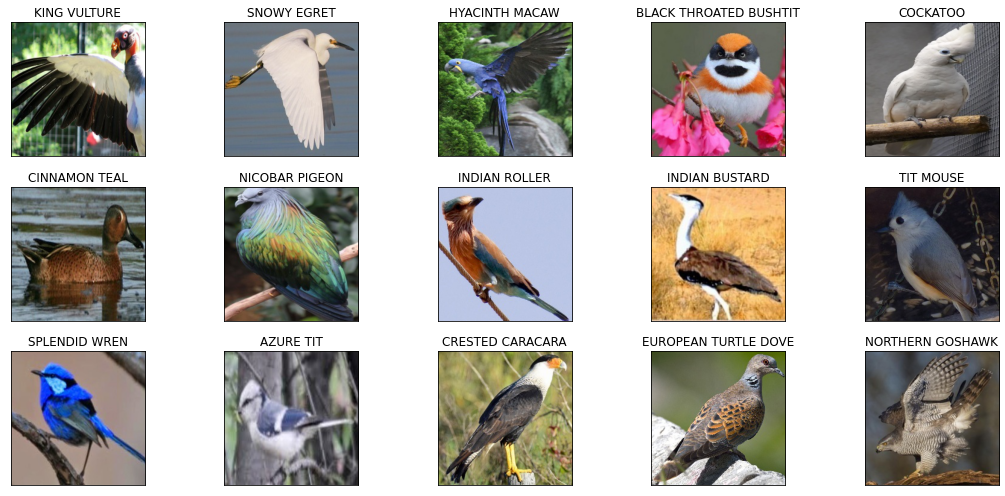

In [129]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

df_sample = df_train.sample(15)
df_sample.reset_index(drop=True, inplace=True)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_sample.path[i]))
    ax.set_title(df_sample.label[i])
plt.tight_layout()
plt.show()

In [130]:


import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F



In [131]:
# Hyper Parameters 
# input_size = 3*3*64
num_classes = 400
# num_epochs = 5
batch_size = 25
learning_rate = 0.001

In [132]:
transform_dict = transforms.Compose([transforms.Resize((120, 120)),
        transforms.RandomResizedCrop(120),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.8],[0.1])
        ]) #normalize! 0.5? //input_size not same as dimensions // 

train_data = torchvision.datasets.ImageFolder(root=directories[1], transform=transform_dict)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)

test_data = torchvision.datasets.ImageFolder(root=directories[0], transform=transform_dict)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4)

valid_data = torchvision.datasets.ImageFolder(root=directories[2], transform=transform_dict)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=5, shuffle=False, drop_last=False, num_workers=4)

In [133]:
class Birdinator(nn.Module): # add model.train, model.eval
    def __init__(self, num_classes):
        super(Birdinator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*6*6, 256)
        self.fc2 = nn.Linear(256, 400)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.pool1(x))
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.pool2(x))
        # print(x.shape)

        x = x.view(-1,64*6*6)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
model = Birdinator(num_classes)

In [134]:
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [135]:
# padded_imgs = [transforms.Pad(padding=padding)(train_data) for padding in (3, 10, 30, 50)]



In [136]:
epochs = 5
for epoch in range(epochs):

    running_loss = 0.0
    model.train()
    model.cuda()
    for i, (batch, labels) in enumerate(train_loader):
        batch = batch.to(torch.device("cuda"))
        labels = labels.to(torch.device("cuda"))
        optimizer.zero_grad()
        y_pred =  model(batch)
        cel = nn.CrossEntropyLoss()
        loss = cel(y_pred,labels)
        loss.backward()
        optimizer.step()
      
        running_loss += loss.item()
        if i % 300 == 299:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 300))
            running_loss = 0.0

print('Finished Training')

[1,   300] loss: 6.000
[1,   600] loss: 5.992
[1,   900] loss: 5.990
[1,  1200] loss: 5.991
[1,  1500] loss: 5.988
[1,  1800] loss: 5.986
[1,  2100] loss: 5.984
[2,   300] loss: 5.977
[2,   600] loss: 5.974
[2,   900] loss: 5.969
[2,  1200] loss: 5.962
[2,  1500] loss: 5.961
[2,  1800] loss: 5.949
[2,  2100] loss: 5.934
[3,   300] loss: 5.922
[3,   600] loss: 5.903
[3,   900] loss: 5.897
[3,  1200] loss: 5.889
[3,  1500] loss: 5.887
[3,  1800] loss: 5.861
[3,  2100] loss: 5.848
[4,   300] loss: 5.841
[4,   600] loss: 5.810
[4,   900] loss: 5.827
[4,  1200] loss: 5.801
[4,  1500] loss: 5.780
[4,  1800] loss: 5.769
[4,  2100] loss: 5.766
[5,   300] loss: 5.752
[5,   600] loss: 5.744
[5,   900] loss: 5.723
[5,  1200] loss: 5.723
[5,  1500] loss: 5.710
[5,  1800] loss: 5.714
[5,  2100] loss: 5.701
Finished Training


In [140]:

PATH = "./save_model"
torch.save(model.state_dict(), PATH)

model = Birdinator(num_classes)

model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [141]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

outputs = model(images)

# for i, (batch, labels) in enumerate(test_loader):
#     y_pred =  model(batch)
#     cel = nn.CrossEntropyLoss()
#     loss = cel(y_pred,labels)
#     # print statistics
#     running_loss += loss.item()
#     if i % 10 == 9:    # print every 10 mini-batches
#         print('[%d, %5d] loss: %.3f' %
#               (epoch + 1, i + 1, running_loss / 10))
#         running_loss = 0.0

# print('Finished Testing')

# outputs = model(images)

# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [142]:
correct = 0
total = 0
cel = nn.CrossEntropyLoss()
birds = []
id = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(valid_loader):
      # if i % 100 == 99:
      #   print("1/4...")
      images, labels = data
      # calculate outputs by running images through the network
      outputs = model(images)
      loss = cel(outputs,labels)
      id.append(i+1)
      birds.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 10000 test images: 1 %


In [143]:
submission_list = np.array([id, birds])
submission_list = np.transpose(submission_list)
submission = pd.DataFrame({'id': id, 'birds': birds})
submission.to_csv('submission.csv', index=False)
submission.tail()

,id,birds
395,396,5.368243
396,397,5.791290
397,398,5.479943
398,399,4.991422
399,400,6.004258


In [144]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in df_test["label"]}
total_pred = {classname: 0 for classname in df_test["label"]}
cel = nn.CrossEntropyLoss()
loglosses = {} # {class: logloss} structure

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        loss = cel(predictions,labels)
        if label in loglosses:
          loglosses[label] += loss.item()
        else:
          loglosses[label] = loss.item()
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[df_test["label"][label]] += 1
            total_pred[df_test["label"][label]] += 1
        print(loglosses)


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

RuntimeError: ignored

In [ ]:
my_submission = pd.DataFrame({'id': test.Id, 'birds': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)